### *An application of open source tools in the finite element analysis : plane stress problem*

In [1]:
from IPython.display import Image

 ### 1. *Abstract* 
 #### This work shows an application of open soures tools that can be useful in the learning process of the  finite element method. More precisely, it is shown here a script written in python which calculates the maximum displacement of a cantilever plate under a pure tension stress state. Everything that is used to solve this problem is free, such as, python it self, Gmsh and Paraview. In order to understand the below script, the reader must have basic knowlegde of the finite element method but also the tools that have been used here. <br> The problem have been kept intentionally simple. Thus, we set a 2x2m steel plate and we construct a mesh with only  two elements, by doing this, the reader can check more easily the results and understand some tricky points, such as the construction of the global stiffness matrix. 
 
 #### Given the way that the mesh has been constructed, the maximum displacement at the plate free end matches exactly with the analytical solution from linear elasticity. 
 
 #### All the files used here can be found in my Github page : https://github.com/igor-barcelos/FEM


### 2. *Basic work flow for a finite element analysis* 
#### We will consider the below workflow to run our finite element analysis in the following example. This workflow must be modified for more complex cases, but it should be good enough for most of all elementary finite element problems.

#### The first two steps (*Geometry and Mesh*) can be done simultaneously, and for those steps, we will use Gmsh, which is an open-source 3D finite element mesh generator. As the following example relies on the linear elastic hypothesis, the  material Young's modulus and Poisson's ratio are enough to solve our problem and therefore only these characteristic are mantioned in *Materials properties* .  
#### Following, in *Derivation of element stiffness matrix* we introduce the FEA_LIBRARY which is nothing more than a library with several types of matrices (e.g, stiffness matrix, strain-displacement matrix..) for different finite elements (eg, Euler-Bernoulli beam element, Timoshenko beam, linear triangular, linear rectangular..) which can be used in any finite element problem that we seek to solve it. For the symbolic stiffness matrix for a linear rectangular element adopted here, see : http://kis.tu.kielce.pl//mo/COLORADO_FEM/colorado/IFEM.Ch17.pdf   
#### The *Derivation of the global stiffness matrix* is the most tricky phase. For this phase, we introduce a mapping function that tells the right location of each value of the element stiffness matrix in the global stiffness matrix. In the *Boundary Conditions* step, we are going to set the knowns values for the displacements and associated loads for specific nodes. Our analysis ends by solving our finite element problem for the unknowns and post-processing our results using Paraview. 

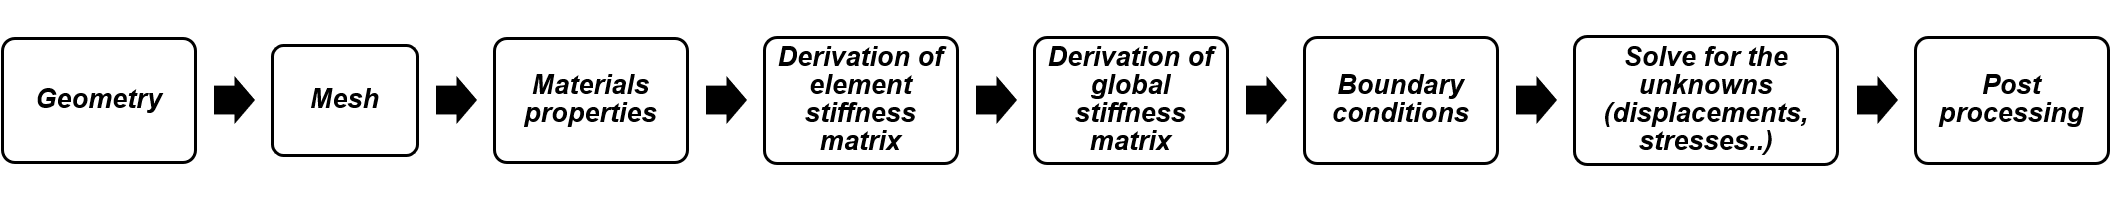

In [2]:
Image(filename="fea_work_flow2.png")

### 3. *Example 1 : Cantilever plate under pure tension stress state*
#### The first problem analyzed in this article is a cantilever square plate under tension. At this point, we are interested in the maximum displacement, and for this we are going to set a finite element mesh with six nodes and two elements. Additionaly, nodes 1 and 4 are fixed, and thus the displacements at those points are zero. Two loads of 3000 N are applied in the *x*-axis at nodes 2 and 3.  
#### Our square plate has young's modulus equals to 2E11 Pa, thickness of 0.2m and length equals to 2m. in order to make our problem as simple as possible, we set the material poisson's ratio equals to zero in the interest of considering only the displacements in the *x* direction.  The analytical solution is quite straightforward and the below figure should clarifie our problem.

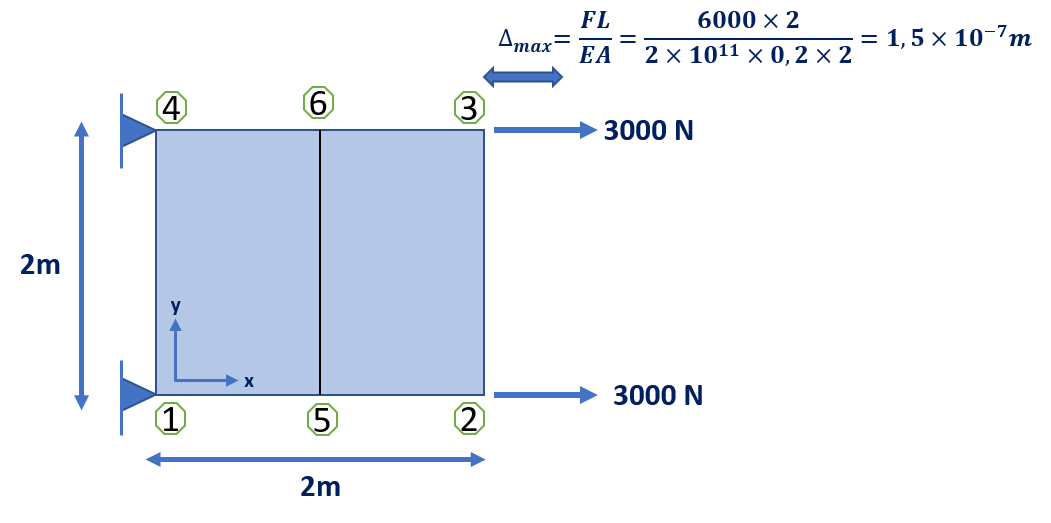

In [3]:
Image(filename="plate_schema.png", width=600, height=600)

In [4]:
# -*- coding: utf-8 -*-

# We start by importing some modules

import sys
import gmsh
import meshio
import numpy as np
import sympy as sym
import pandas as pd
sys.path.append(r'C:\Users\barce\Desktop\FEA')
from FEA_LIBRARY import STIFF_MATRIX_RECT
from sympy.interactive import printing

printing.init_printing(use_latex = True)

### 3. *Geometry and Mesh* ###


In [5]:
# This step can be divided into two parts. First, we are going to use the Gmsh module to create a function that 
# generates a square plate with six nodes and two elements. Secondly, using the module Meshio we are going to read 
# this mesh. The below code must do the job.

#======================================================================
#                       CREATING MESH
#======================================================================

def MESH():
    gmsh.initialize()

    gmsh.model.add("mesh_plate")

    gmsh.option.setNumber("Mesh.MeshSizeFactor", 1)
    p1 = gmsh.model.geo.addPoint(0,0,0)
    p2 = gmsh.model.geo.addPoint(2,0,0)
    p3 = gmsh.model.geo.addPoint(2,2,0)
    p4 = gmsh.model.geo.addPoint(0,2,0)
    
    # Creating a four-node square plate
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)

    # Setting two more nodes, making a six-node-square plate
    gmsh.model.geo.mesh.setTransfiniteCurve(l1, 3) 
    gmsh.model.geo.mesh.setTransfiniteCurve(l2, 2)
    gmsh.model.geo.mesh.setTransfiniteCurve(l3, 3)
    gmsh.model.geo.mesh.setTransfiniteCurve(l4, 2)
    gmsh.model.geo.addCurveLoop([l1, l2, l3, l4], 1)
    # Creating a surface
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.mesh.setTransfiniteSurface(1)
    gmsh.model.geo.mesh.setRecombine(2, 1)

    gmsh.model.geo.synchronize()

    fixed = gmsh.model.addPhysicalGroup(1, [1], 5)
    gmsh.model.setPhysicalName(1, fixed, "Fixed")
    
    # Meshing and Saving in vtk format
    gmsh.option.setNumber("Mesh.SaveAll", 1)
    gmsh.model.mesh.generate(2)
    mesh_file = gmsh.write("mesh_plate.vtk")
    
    # Uncomment the below two lines if you want to see the mesh in Gmsh interface
#     if '-nopopup' not in sys.argv:
#         gmsh.fltk.run()

    return mesh_file

#======================================================================
#                       READING MESH
#======================================================================
#MESH()

mesh = meshio.read("mesh_plate.vtk")

### 4. *Materials Properties* ###

In [6]:
# Setting material young's module, poisson's ratio and thickness
E_young = 2E11
v_p = 0
thick = 0.2

### 5. *Derivation of element stiffness matrix* ###


In [7]:
# The derivation of element stiffness matrix uses the FEA_LIBRARY, which is a python file that returns some kind 
# of element matrix (eg, stiffness, strain-displacement...) as an symbolic sympy matrix for the considered finite element,
# which is for our case the linear rectangular element. Once the symbolic element stiffness matrix is captured, 
# we only need to substitute the values. Since we have two elements, two stiffness matrix are generated and 
# inserted in a dictionnary. 

#======================================================================
#                       VARIABLES DECLARATION
#======================================================================


NNodes= np.shape(mesh.points)[0]                   ## Number of noeds
NElements = np.shape(mesh.cells_dict['quad'])[0]   ## Number of elements
NDOF=2*NNodes                                      ## Number of degrees of freedom

#======================================================================
#         REPLACING VALUES AND GENERATING ELEMENT STIFFNESS MATRIX
#======================================================================

#====================================================================== 
# GETTING ELEMENT DIMENSIONS  
#======================================================================

dim_element = np.zeros((NElements,2))
K_dict = {}
for i in range(0,NElements):
   
   x_final =  mesh.points[mesh.cells_dict['quad'][i][1]][0]
   x_initial = mesh.points[mesh.cells_dict['quad'][i][0]][0]

   y_final  = mesh.points[mesh.cells_dict['quad'][i][2]][1]
   y_initial = mesh.points[mesh.cells_dict['quad'][i][1]][1]
   dim_x = x_final - x_initial
   dim_y = y_final - y_initial
   dim_element[i,0] = dim_x
   dim_element[i,1] = dim_y

#====================================================================== 
# CREATING A DICTIONARY WITH ALL ELEMENT STIFNESS MATRICES    
#======================================================================
   K_temp = STIFF_MATRIX_RECT(E=E_young,t=thick,β =dim_element[i,0]/dim_element[i,1],v=v_p)
   K_temp = np.array(K_temp).astype(np.float64)
   K_dict['K'+str(i)] = K_temp

In [8]:
# We can use the pandas Data Frame to visualize the stiffness matrix of the 1st element 
pd.DataFrame(data = K_dict['K0'])


,0,1,2,3,4,5,6,7
0,3.000000e+10,5.000000e+09,-2.500000e+10,-5.000000e+09,-1.500000e+10,-5.000000e+09,1.000000e+10,5.000000e+09
1,5.000000e+09,2.000000e+10,5.000000e+09,-1.000000e+10,-5.000000e+09,-1.000000e+10,-5.000000e+09,3.487729e-02
2,-2.500000e+10,5.000000e+09,3.000000e+10,-5.000000e+09,1.000000e+10,-5.000000e+09,-1.500000e+10,5.000000e+09
3,-5.000000e+09,-1.000000e+10,-5.000000e+09,2.000000e+10,5.000000e+09,3.487729e-02,5.000000e+09,-1.000000e+10
4,-1.500000e+10,-5.000000e+09,1.000000e+10,5.000000e+09,3.000000e+10,5.000000e+09,-2.500000e+10,-5.000000e+09
5,-5.000000e+09,-1.000000e+10,-5.000000e+09,3.487729e-02,5.000000e+09,2.000000e+10,5.000000e+09,-1.000000e+10
6,1.000000e+10,-5.000000e+09,-1.500000e+10,5.000000e+09,-2.500000e+10,5.000000e+09,3.000000e+10,-5.000000e+09
7,5.000000e+09,3.487729e-02,5.000000e+09,-1.000000e+10,-5.000000e+09,-1.000000e+10,-5.000000e+09,2.000000e+10


### 6. *Derivation of global stifness matrix* ###

In [9]:
# In order to generate the global sitffness matrix, we are goint to set a dictionnary, called L_M that contais the position
# of each degree of freedom at the element level in the global stiffness matrix. Doing that, we are able to place correctly 
# each value of element stiffness matrix in the global matrix. Please, take your time to really understand this step. Is's
# here where the magic happens.

#======================================================================
#               GENERATING GLOBAL STIFFNESS MATRIX
#======================================================================
KG = np.zeros((NDOF,NDOF))

L_M= {}
CONEC_DIC = {}


for element in range(0,NElements):
    L_M['EL'+str(element)] = []
    CONEC_DIC['EL'+str(element)] = np.repeat(mesh.cells_dict['quad'][element]+1,2)
    for i in range(0,8):
        if i%2 == 0:
            value = CONEC_DIC['EL'+str(element)][i]*2-2
        else:
            value = CONEC_DIC['EL'+str(element)][i]*2-1
        L_M['EL'+str(element)].append(value)

for element in range(0,NElements):            
    for i in range(0,8):
        x_global = L_M['EL'+str(element)][i]
        for j in range(0,8):
            value = K_dict['K'+str(element)][i,j]
            y_global = L_M['EL'+str(element)][j]
            KG[x_global,y_global] += KG[x_global,y_global] + value

In [10]:
# Once again, We use the pandas Data Frame to visualize the global stiffness matrix
pd.DataFrame(data = KG)

,0,1,2,3,4,5,6,7,8,9,10,11
0,3.000000e+10,5.000000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+10,5.000000e+09,-2.500000e+10,-5.000000e+09,-1.500000e+10,-5.000000e+09
1,5.000000e+09,2.000000e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.000000e+09,3.487729e-02,5.000000e+09,-1.000000e+10,-5.000000e+09,-1.000000e+10
2,0.000000e+00,0.000000e+00,3.000000e+10,-5.000000e+09,1.000000e+10,-5.000000e+09,0.000000e+00,0.000000e+00,-2.500000e+10,5.000000e+09,-1.500000e+10,5.000000e+09
3,0.000000e+00,0.000000e+00,-5.000000e+09,2.000000e+10,5.000000e+09,-3.487581e-02,0.000000e+00,0.000000e+00,-5.000000e+09,-1.000000e+10,5.000000e+09,-1.000000e+10
4,0.000000e+00,0.000000e+00,1.000000e+10,5.000000e+09,3.000000e+10,5.000000e+09,0.000000e+00,0.000000e+00,-1.500000e+10,-5.000000e+09,-2.500000e+10,-5.000000e+09
5,0.000000e+00,0.000000e+00,-5.000000e+09,-3.487581e-02,5.000000e+09,2.000000e+10,0.000000e+00,0.000000e+00,-5.000000e+09,-1.000000e+10,5.000000e+09,-1.000000e+10
6,1.000000e+10,-5.000000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+10,-5.000000e+09,-1.500000e+10,5.000000e+09,-2.500000e+10,5.000000e+09
7,5.000000e+09,3.487729e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.000000e+09,2.000000e+10,5.000000e+09,-1.000000e+10,-5.000000e+09,-1.000000e+10
8,-2.500000e+10,5.000000e+09,-2.500000e+10,-5.000000e+09,-1.500000e+10,-5.000000e+09,-1.500000e+10,5.000000e+09,9.000000e+10,-5.000000e+09,3.000000e+10,-5.000000e+09
9,-5.000000e+09,-1.000000e+10,5.000000e+09,-1.000000e+10,-5.000000e+09,-1.000000e+10,5.000000e+09,-1.000000e+10,-5.000000e+09,6.000000e+10,5.000000e+09,3.487877e-02


### 7. *Boundary conditions* ###

In [11]:
# In this phase, we create the load vector and then we can replace the load values in the right positions, meaning nodes
# 2 and 3. Following, as the displacements at the nodes 1 and 4 are zero, we delete their respectives lines and column in 
# the global stiffness matrix and load vector before solving our problem

LOADS = np.zeros((NDOF,1))

CHARGE = 3000

LOADS[2,0] = CHARGE
LOADS[4,0] = CHARGE

KG =np.linalg.inv(KG)


fixed_points = []
for i in range(0,len(mesh.points)):
    if mesh.points[i][0] ==0 and mesh.points[i][1]>=0 and mesh.points[i][1]<=2 :
        fixed_points.append((i+1))


for i in reversed(range(len(fixed_points))):
    position_1 = fixed_points[i]*2-2
    position_2 = fixed_points[i]*2-1
    KG = np.delete(KG,position_2,0)
    KG = np.delete(KG,position_2,1)
    KG = np.delete(KG,position_1,0)
    KG = np.delete(KG,position_1,1)
    LOADS = np.delete(LOADS,position_2,0)
    LOADS = np.delete(LOADS,position_1,0)




### 8. *Solving for the unknows* ###

In [12]:
# As we seek to analyze only the displacements, we are solving only for this. 

displacements = KG.dot(LOADS)

# inserting the zero values that correspond to the fixed nodes 1 and 4

for i in range(0,len(fixed_points)):
    position_1 = fixed_points[i]*2-2
    position_2 = fixed_points[i]*2-1
    displacements = np.insert(displacements,position_1,0)
    displacements = np.insert(displacements,position_2,0)


In [13]:
pd.DataFrame(data = displacements)

,0
0,0.000000e+00
1,0.000000e+00
2,1.500000e-07
3,2.646978e-23
4,1.500000e-07
5,5.293956e-23
6,0.000000e+00
7,0.000000e+00
8,7.500000e-08
9,1.323489e-23


### 9. *Post-processing* ###

In [14]:
# Here we begin post processing our results, which means that we are going to create a vtk file in order to visualize the 
# displacements using Paraview. It is a quite simple process : first, we create our finite element mesh using our node
# and element data (location of nodes, element type and connectivity), and then for each node of this mesh we define
# the respective displacement value calculated previously. We finish by creating the vtk file.

displacements_x = []
for i in range(0,len(displacements)):  # getting only the displacements in the x direction
    if i %2 ==0:
        value = displacements[i]
        displacements_x.append(value)

point_data={}
point_data['displacement_x']=displacements_x[:]

displacements_x = np.array(displacements_x)
points = mesh.points                           # getting the location of nodes  
cells = [('quad', mesh.cells_dict['quad'])]    # getting the connectivity 
point_data={}
                           
point_data['displacement_x'] = displacements_x[:]     # defining displacement data 

mesh.point_data['displacement_x']= displacements_x[:] # definig the displacement in each node 

meshio.write_points_cells(                # creating the mesh
        'displacement_x.vtk',
        points,
        cells,
        point_data= mesh.point_data)


meshio.write('displacement_x.vtk', mesh) # creating vtk file 

# We can use Paraview in order to generate the below image, which shows the displacements in the x direction. 


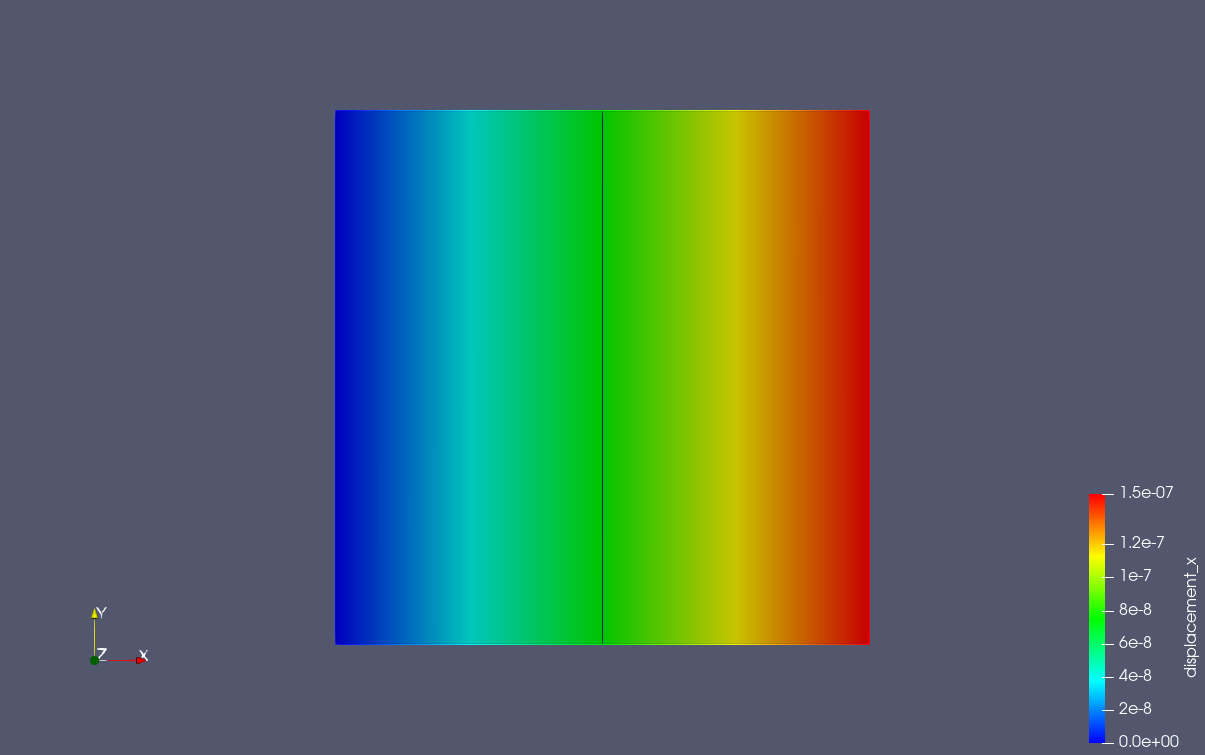

In [15]:
Image(filename="displ_x.png", width=600, height=600)

### *Conclusion* ###
#### The python script  presented here has shown how we can use open source tools in order to solve mechanical problems using the finite element method. Programming the finite elment method can be a very efficient learning strategy, as we are completely in control of our hole model, and therefore it is easier to know if our model is working as should be, and if he is not, we can go deeper as possible to find out the reasons. 
#### Our problem has been intentionally kept simple, we could complicate by working with a denser finite element mesh for example, but in the way that the problem has been set, the reader can check the consistency of the results even manually, which can be quite hepfull during the learning process. 
#### The solution of the finite element model matches exactly with the analytical one, as it should be, given the way that the mesh has been constructed.  Probably, with a denser mesh the results would not match exactly, but with a little difference. 